# Практическая работа №8: Разработка гибридного приложения для CPU и GPU

### Теоретическая часть:
1. Гибридные вычисления:
- Гибридные вычисления — это подход, при котором задачи распределяются
между CPU и GPU для достижения максимальной производительности.
- CPU используется для последовательных задач и управления данными, а
GPU — для параллельных вычислений.
2. OpenMP:
- OpenMP — это API для многопоточного программирования на CPU.
Позволяет легко распараллеливать циклы и задачи.
3. CUDA:
- CUDA — это платформа для параллельных вычислений на GPU. Позволяет
использовать тысячи ядер GPU для выполнения параллельных задач.
4. Передача данных между CPU и GPU:
- Данные передаются между CPU и GPU через шину PCI Express. Это может
стать узким местом в производительности, поэтому важно минимизировать
количество передач.

### Практическая часть:
Задание 1: Реализация обработки массива на CPU с использованием OpenMP
1. Создайте массив данных размером `N` (например, `N = 1 000 000`).
2. Реализуйте функцию для обработки массива на CPU с использованием
OpenMP. Например, умножьте каждый элемент массива на 2.
3. Замерьте время выполнения обработки на CPU.

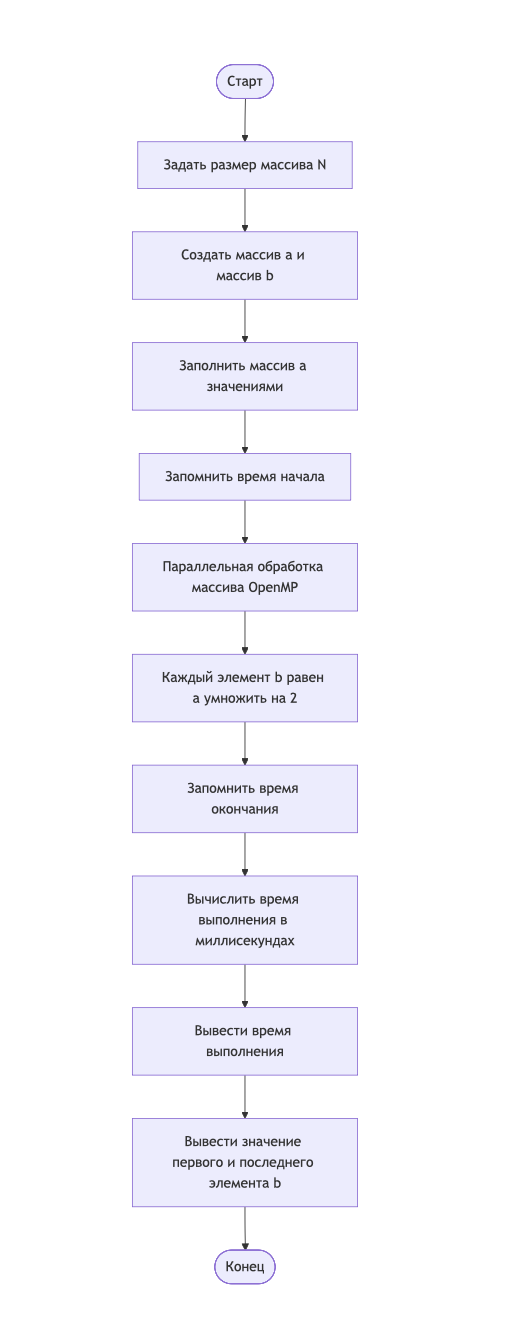

In [14]:
%%writefile task1_cpu_openmp.cpp
#include <omp.h>                               // Подключаем OpenMP
#include <chrono>                              // Таймер
#include <cstdio>                              // printf
#include <vector>                              // std::vector

int main() {                                   // Точка входа
    const int N = 1'000'000;                   // Размер массива
    std::vector<float> a(N);                   // Входной массив
    std::vector<float> b(N);                   // Выходной массив

    for (int i = 0; i < N; i++) {              // Заполняем массив
        a[i] = (float)(i % 100) * 0.5f;        // Детерминированные значения
    }

    auto t0 = std::chrono::steady_clock::now();// Засекаем старт
    #pragma omp parallel for schedule(static)  // Параллельный цикл OpenMP
    for (int i = 0; i < N; i++) {              // Проход по элементам
        b[i] = a[i] * 2.0f;                    // Обработка: умножение на 2
    }
    auto t1 = std::chrono::steady_clock::now();// Засекаем конец

    double ms = std::chrono::duration<double, std::milli>(t1 - t0).count(); // Время в мс

    printf("Task1 CPU(OpenMP): N=%d | time=%.3f ms\n", N, ms); // Печать результата
    printf("Check: b[0]=%.2f, b[N-1]=%.2f\n", b[0], b[N-1]);   // Быстрая проверка

    return 0;                                   // Успешный выход
}


Overwriting task1_cpu_openmp.cpp


In [15]:
!g++ -O3 -fopenmp task1_cpu_openmp.cpp -o task1_cpu_openmp
!./task1_cpu_openmp


Task1 CPU(OpenMP): N=1000000 | time=0.400 ms
Check: b[0]=0.00, b[N-1]=99.00


Задание 2: Реализация обработки массива на GPU с использованием CUDA
1. Скопируйте массив данных на GPU.
2. Реализуйте ядро CUDA для обработки массива на GPU. Например, умножьте
каждый элемент массива на 2.
3. Скопируйте обработанные данные обратно на CPU.
4. Замерьте время выполнения обработки на GPU.

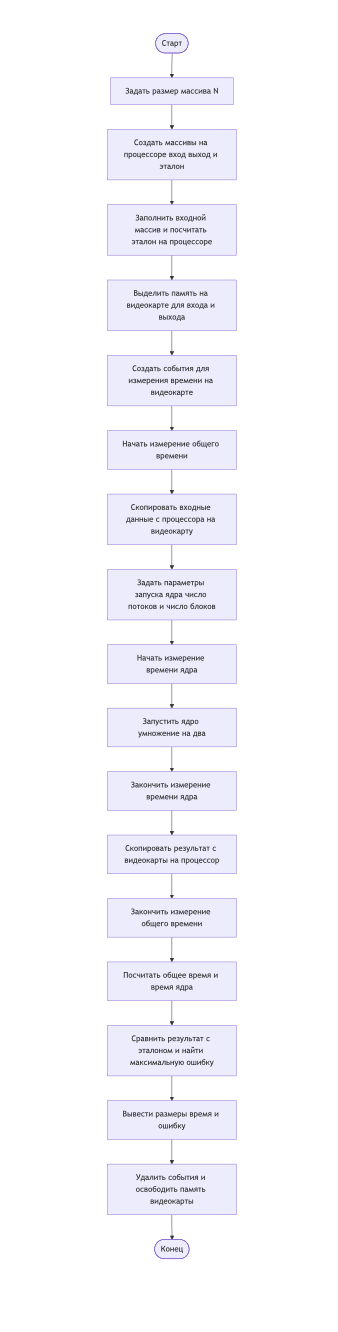

In [16]:
%%writefile task2_gpu_cuda.cu
#include <cuda_runtime.h>                              // CUDA runtime
#include <cstdio>                                      // printf
#include <vector>                                      // std::vector
#include <cmath>                                       // fabsf

#define CUDA_CHECK(call) do {                          \
    cudaError_t err = (call);                          \
    if (err != cudaSuccess) {                          \
        printf("CUDA error %s:%d: %s\n",               \
               __FILE__, __LINE__, cudaGetErrorString(err)); \
        return 1;                                      \
    }                                                  \
} while(0)

__global__ void mul2_kernel(const float* in, float* out, int n) { // Ядро CUDA
    int idx = blockIdx.x * blockDim.x + threadIdx.x;              // Индекс потока
    if (idx < n) {                                                // Проверка границ
        out[idx] = in[idx] * 2.0f;                                // Умножаем на 2
    }
}

int main() {                                                      // Точка входа
    const int N = 1'000'000;                                     // Размер массива
    std::vector<float> h_in(N);                                   // Хост вход
    std::vector<float> h_out(N);                                  // Хост выход
    std::vector<float> h_ref(N);                                  // Эталон CPU

    for (int i = 0; i < N; i++) {                                 // Инициализация
        h_in[i] = (float)(i % 100) * 0.5f;                        // Значения
        h_ref[i] = h_in[i] * 2.0f;                                // CPU эталон
    }

    float* d_in = nullptr;                                        // Указатель GPU вход
    float* d_out = nullptr;                                       // Указатель GPU выход
    CUDA_CHECK(cudaMalloc(&d_in, N * sizeof(float)));             // Выделяем память на GPU
    CUDA_CHECK(cudaMalloc(&d_out, N * sizeof(float)));            // Выделяем память на GPU

    cudaEvent_t start, stop, kstart, kstop;                       // CUDA события
    CUDA_CHECK(cudaEventCreate(&start));                          // Создаём start
    CUDA_CHECK(cudaEventCreate(&stop));                           // Создаём stop
    CUDA_CHECK(cudaEventCreate(&kstart));                         // Создаём kstart
    CUDA_CHECK(cudaEventCreate(&kstop));                          // Создаём kstop

    CUDA_CHECK(cudaEventRecord(start));                           // Старт total времени
    CUDA_CHECK(cudaMemcpy(d_in, h_in.data(), N * sizeof(float), cudaMemcpyHostToDevice)); // H2D

    int block = 256;                                              // Потоки в блоке
    int grid = (N + block - 1) / block;                           // Кол-во блоков

    CUDA_CHECK(cudaEventRecord(kstart));                          // Старт kernel времени
    mul2_kernel<<<grid, block>>>(d_in, d_out, N);                 // Запуск ядра
    CUDA_CHECK(cudaEventRecord(kstop));                           // Стоп kernel времени
    CUDA_CHECK(cudaGetLastError());                               // Проверка ошибок запуска

    CUDA_CHECK(cudaMemcpy(h_out.data(), d_out, N * sizeof(float), cudaMemcpyDeviceToHost)); // D2H
    CUDA_CHECK(cudaEventRecord(stop));                            // Стоп total времени
    CUDA_CHECK(cudaEventSynchronize(stop));                       // Ждём завершения

    float total_ms = 0.0f;                                        // Время total
    float kernel_ms = 0.0f;                                       // Время kernel
    CUDA_CHECK(cudaEventElapsedTime(&total_ms, start, stop));     // Считаем total
    CUDA_CHECK(cudaEventElapsedTime(&kernel_ms, kstart, kstop));  // Считаем kernel

    float max_err = 0.0f;                                         // Ошибка
    for (int i = 0; i < N; i++) {                                 // Сравнение
        float e = fabsf(h_out[i] - h_ref[i]);                     // Абс ошибка
        if (e > max_err) max_err = e;                             // Максимум
    }

    printf("Task2 GPU(CUDA): N=%d | total=%.3f ms | kernel=%.3f ms | max_err=%.6g\n",
           N, total_ms, kernel_ms, max_err);                      // Печать

    CUDA_CHECK(cudaEventDestroy(start));                          // Удаляем события
    CUDA_CHECK(cudaEventDestroy(stop));                           // Удаляем события
    CUDA_CHECK(cudaEventDestroy(kstart));                         // Удаляем события
    CUDA_CHECK(cudaEventDestroy(kstop));                          // Удаляем события

    CUDA_CHECK(cudaFree(d_in));                                   // Освобождаем GPU память
    CUDA_CHECK(cudaFree(d_out));                                  // Освобождаем GPU память

    return 0;                                                     // Успешный выход
}


Overwriting task2_gpu_cuda.cu


In [17]:
!nvcc -O3 -arch=sm_75 task2_gpu_cuda.cu -o task2_gpu_cuda
!./task2_gpu_cuda


Task2 GPU(CUDA): N=1000000 | total=2.086 ms | kernel=0.085 ms | max_err=0


Задание 3: Гибридная обработка массива
1. Разделите массив на две части: первая половина обрабатывается на CPU,
вторая — на GPU.
2. Реализуйте гибридное приложение, которое выполняет обработку массива
на CPU и GPU одновременно.
3. Замерьте общее время выполнения гибридной обработки.

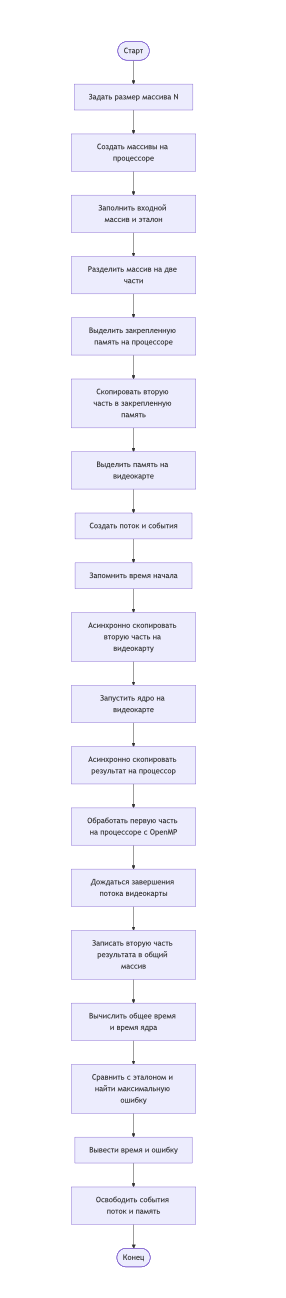

In [18]:
%%writefile task3_hybrid.cu
#include <cuda_runtime.h>                                  // CUDA runtime
#include <omp.h>                                           // OpenMP
#include <cstdio>                                          // printf
#include <vector>                                          // std::vector
#include <chrono>                                          // таймер
#include <cmath>                                           // fabsf

#define CUDA_CHECK(call) do {                              \
    cudaError_t err = (call);                              \
    if (err != cudaSuccess) {                              \
        printf("CUDA error %s:%d: %s\n",                   \
               __FILE__, __LINE__, cudaGetErrorString(err)); \
        return 1;                                          \
    }                                                      \
} while(0)

__global__ void mul2_kernel(const float* in, float* out, int n) { // CUDA ядро
    int idx = blockIdx.x * blockDim.x + threadIdx.x;              // Индекс потока
    if (idx < n) out[idx] = in[idx] * 2.0f;                       // Умножаем
}

void cpu_mul2_openmp(const float* in, float* out, int n) {        // CPU функция
    #pragma omp parallel for schedule(static)                     // OpenMP цикл
    for (int i = 0; i < n; i++) out[i] = in[i] * 2.0f;            // Умножаем
}

double now_ms() {                                                 // Текущее время в мс
    using namespace std::chrono;                                  // chrono
    return duration<double, std::milli>(steady_clock::now().time_since_epoch()).count(); // мс
}

int main() {                                                       // main
    const int N = 10'000'000;                                      // Размер массива (лучше для гибрида)
    std::vector<float> h_in(N);                                     // Вход
    std::vector<float> h_ref(N);                                    // Эталон CPU
    std::vector<float> h_out(N);                                    // Гибридный выход

    for (int i = 0; i < N; i++) {                                   // Заполняем
        h_in[i] = (float)(i % 100) * 0.5f;                          // Значение
        h_ref[i] = h_in[i] * 2.0f;                                  // Эталон
    }

    int half = N / 2;                                               // Делим пополам
    int n_cpu = half;                                               // CPU часть
    int n_gpu = N - half;                                           // GPU часть

    float* h_pinned_in = nullptr;                                   // pinned вход
    float* h_pinned_out = nullptr;                                  // pinned выход
    CUDA_CHECK(cudaMallocHost(&h_pinned_in, n_gpu * sizeof(float))); // pinned alloc
    CUDA_CHECK(cudaMallocHost(&h_pinned_out, n_gpu * sizeof(float)));// pinned alloc

    for (int i = 0; i < n_gpu; i++) {                                // Копируем во pinned
        h_pinned_in[i] = h_in[half + i];                             // Вторая половина
    }

    float* d_in = nullptr;                                           // GPU вход
    float* d_out = nullptr;                                          // GPU выход
    CUDA_CHECK(cudaMalloc(&d_in, n_gpu * sizeof(float)));            // GPU malloc
    CUDA_CHECK(cudaMalloc(&d_out, n_gpu * sizeof(float)));           // GPU malloc

    cudaStream_t stream;                                             // stream
    CUDA_CHECK(cudaStreamCreate(&stream));                           // create stream

    cudaEvent_t kstart, kstop;                                       // события kernel
    CUDA_CHECK(cudaEventCreate(&kstart));                            // create
    CUDA_CHECK(cudaEventCreate(&kstop));                             // create

    double t0 = now_ms();                                            // общий старт

    CUDA_CHECK(cudaMemcpyAsync(d_in, h_pinned_in, n_gpu * sizeof(float),
                               cudaMemcpyHostToDevice, stream));     // async H2D

    int block = 256;                                                 // блок
    int grid = (n_gpu + block - 1) / block;                          // grid

    CUDA_CHECK(cudaEventRecord(kstart, stream));                     // kernel start
    mul2_kernel<<<grid, block, 0, stream>>>(d_in, d_out, n_gpu);     // kernel async
    CUDA_CHECK(cudaEventRecord(kstop, stream));                      // kernel stop
    CUDA_CHECK(cudaGetLastError());                                  // check

    CUDA_CHECK(cudaMemcpyAsync(h_pinned_out, d_out, n_gpu * sizeof(float),
                               cudaMemcpyDeviceToHost, stream));     // async D2H

    cpu_mul2_openmp(h_in.data(), h_out.data(), n_cpu);               // CPU обрабатывает первую половину

    CUDA_CHECK(cudaStreamSynchronize(stream));                       // ждём завершения GPU части

    for (int i = 0; i < n_gpu; i++) {                                // переносим обратно
        h_out[half + i] = h_pinned_out[i];                           // ставим вторую половину
    }

    double t1 = now_ms();                                            // общий конец
    double total_ms = t1 - t0;                                       // время гибрида

    float kernel_ms = 0.0f;                                          // время kernel
    CUDA_CHECK(cudaEventElapsedTime(&kernel_ms, kstart, kstop));     // elapsed kernel

    float max_err = 0.0f;                                            // ошибка
    for (int i = 0; i < N; i++) {                                    // проверка
        float e = fabsf(h_out[i] - h_ref[i]);                        // abs diff
        if (e > max_err) max_err = e;                                // max
    }

    printf("Task3 HYBRID: N=%d | total=%.3f ms | gpu_kernel=%.3f ms | max_err=%.6g\n",
           N, total_ms, kernel_ms, max_err);                         // печать

    CUDA_CHECK(cudaEventDestroy(kstart));                            // destroy
    CUDA_CHECK(cudaEventDestroy(kstop));                             // destroy
    CUDA_CHECK(cudaStreamDestroy(stream));                           // destroy stream
    CUDA_CHECK(cudaFree(d_in));                                      // free
    CUDA_CHECK(cudaFree(d_out));                                     // free
    CUDA_CHECK(cudaFreeHost(h_pinned_in));                           // free pinned
    CUDA_CHECK(cudaFreeHost(h_pinned_out));                          // free pinned

    return 0;                                                        // выход
}


Overwriting task3_hybrid.cu


In [19]:
!nvcc -O3 -arch=sm_75 -Xcompiler -fopenmp task3_hybrid.cu -o task3_hybrid
!./task3_hybrid


Task3 HYBRID: N=10000000 | total=9.341 ms | gpu_kernel=0.222 ms | max_err=0


Задание 4: Анализ производительности
1. Сравните время выполнения обработки массива на CPU, GPU и в гибридном
режиме.
2. Проведите анализ производительности и определите, в каких случаях
гибридный подход дает наибольший выигрыш.

In [10]:
%%writefile task4_benchmark.cu
#include <cuda_runtime.h>                     // подключаем CUDA (память на GPU, копирование, события)
#include <omp.h>                              // OpenMP для параллельности на CPU
#include <cstdio>                             // чтобы делать printf
#include <vector>                             // вектор вместо обычных массивов
#include <chrono>                             // для замера времени на CPU
#include <fstream>                            // чтобы сохранить результаты в CSV файл
#include <iomanip>                            // для красивого вывода чисел (точность)
#include <cmath>                              // fabsf - модуль для float

// Макрос чтобы проверять ошибки CUDA (очень удобно, иначе ошибки тяжело ловить)
#define CUDA_CHECK(call) do {                                         \
  cudaError_t err = (call);                                           \
  if (err != cudaSuccess) {                                           \
    printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__,              \
           cudaGetErrorString(err));                                  \
    return 1;                                                         \
  }                                                                   \
} while(0)

// CUDA ядро: умножаем каждый элемент на 2
__global__ void mul2_kernel(const float* in, float* out, int n) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;    // индекс элемента для текущего потока
  if (idx < n) {                                      // защита чтобы не выйти за границу массива
    out[idx] = in[idx] * 2.0f;                        // основная операция (умножение на 2)
  }
}

// CPU функция с OpenMP: тоже умножаем элементы на 2
void cpu_mul2_openmp(const float* in, float* out, int n) {
  #pragma omp parallel for schedule(static)           // делим цикл по потокам
  for (int i = 0; i < n; i++) {                       // обычный цикл по массиву
    out[i] = in[i] * 2.0f;                            // обработка на CPU
  }
}

// функция чтобы получить текущее время в миллисекундах
double now_ms() {
  using namespace std::chrono;                        // чтобы не писать std::chrono::
  return duration<double, std::milli>(
           steady_clock::now().time_since_epoch()
         ).count();                                   // возвращаем время в ms
}

// функция проверки: считаем максимальную разницу между двумя массивами
float max_abs_diff(const float* a, const float* b, int n) {
  float m = 0.0f;                                     // тут будет максимальная ошибка
  for (int i = 0; i < n; i++) {                       // проверяем все элементы
    float d = fabsf(a[i] - b[i]);                     // считаем |a-b|
    if (d > m) m = d;                                 // если нашли больше ошибку, обновляем
  }
  return m;                                           // возвращаем итоговую максимальную ошибку
}

int main() {
  std::vector<int> sizes = {1024, 100000, 1000000, 10000000}; // размеры массивов (чтобы сравнить скорость)

  std::ofstream csv("task4_results.csv");             // создаём файл для результатов
  csv << "N,cpu_ms,gpu_total_ms,gpu_kernel_ms,hybrid_ms,hybrid_gpu_kernel_ms,err_gpu,err_hybrid\n"; // заголовки

  const int BLOCK = 256;                              // размер блока CUDA (стандартное значение)

  for (int N : sizes) {                               // цикл по разным N
    printf("\n=== N = %d ===\n", N);                  // выводим текущий N

    std::vector<float> h_in(N);                       // входной массив
    std::vector<float> h_cpu(N);                      // результат CPU
    std::vector<float> h_gpu(N);                      // результат GPU
    std::vector<float> h_hybrid(N);                   // результат гибрид

    for (int i = 0; i < N; i++) {                     // заполняем входной массив
      h_in[i] = (float)(i % 100) * 0.5f;              // простые значения (чтобы было удобно проверять)
    }

    // ================= CPU(OpenMP) =================
    double t0 = now_ms();                             // начало замера CPU
    cpu_mul2_openmp(h_in.data(), h_cpu.data(), N);    // запускаем CPU обработку
    double t1 = now_ms();                             // конец замера CPU
    double cpu_ms = t1 - t0;                          // время CPU
    printf("CPU(OpenMP): %.3f ms\n", cpu_ms);          // вывод времени CPU

    // ================= GPU(CUDA) =================
    float *d_in = nullptr, *d_out = nullptr;          // указатели на память GPU
    CUDA_CHECK(cudaMalloc(&d_in, N * sizeof(float))); // выделяем память под вход на GPU
    CUDA_CHECK(cudaMalloc(&d_out, N * sizeof(float)));// выделяем память под выход на GPU

    cudaEvent_t s, e, ks, ke;                         // события для замера времени на GPU
    CUDA_CHECK(cudaEventCreate(&s));                  // старт total
    CUDA_CHECK(cudaEventCreate(&e));                  // стоп total
    CUDA_CHECK(cudaEventCreate(&ks));                 // старт kernel
    CUDA_CHECK(cudaEventCreate(&ke));                 // стоп kernel

    CUDA_CHECK(cudaEventRecord(s));                   // начинаем общий замер времени GPU

    CUDA_CHECK(cudaMemcpy(d_in, h_in.data(), N * sizeof(float), cudaMemcpyHostToDevice)); // копирование CPU→GPU

    int GRID = (N + BLOCK - 1) / BLOCK;               // сколько блоков нужно, чтобы покрыть N элементов
    CUDA_CHECK(cudaEventRecord(ks));                  // старт замера kernel
    mul2_kernel<<<GRID, BLOCK>>>(d_in, d_out, N);     // запускаем kernel
    CUDA_CHECK(cudaEventRecord(ke));                  // стоп замера kernel
    CUDA_CHECK(cudaGetLastError());                   // проверка запуска kernel

    CUDA_CHECK(cudaMemcpy(h_gpu.data(), d_out, N * sizeof(float), cudaMemcpyDeviceToHost)); // копирование GPU→CPU

    CUDA_CHECK(cudaEventRecord(e));                   // заканчиваем общий замер
    CUDA_CHECK(cudaEventSynchronize(e));              // ждём чтобы всё точно закончилось

    float gpu_total_ms = 0.0f;                        // время total
    float gpu_kernel_ms = 0.0f;                       // время kernel
    CUDA_CHECK(cudaEventElapsedTime(&gpu_total_ms, s, e));  // считаем total
    CUDA_CHECK(cudaEventElapsedTime(&gpu_kernel_ms, ks, ke));// считаем kernel

    float err_gpu = max_abs_diff(h_cpu.data(), h_gpu.data(), N); // проверяем правильность GPU
    printf("GPU: total=%.3f ms | kernel=%.3f ms | err=%.6g\n",
           gpu_total_ms, gpu_kernel_ms, err_gpu);     // печать GPU результатов

    CUDA_CHECK(cudaEventDestroy(s));                  // удаляем события
    CUDA_CHECK(cudaEventDestroy(e));
    CUDA_CHECK(cudaEventDestroy(ks));
    CUDA_CHECK(cudaEventDestroy(ke));

    CUDA_CHECK(cudaFree(d_in));                       // освобождаем память GPU
    CUDA_CHECK(cudaFree(d_out));

    // ================= HYBRID =================
    int half = N / 2;                                 // делим массив пополам
    int n_cpu = half;                                 // первая половина на CPU
    int n_gpu = N - half;                             // вторая половина на GPU

    float* h_pin_in = nullptr;                        // pinned память для входа GPU части
    float* h_pin_out = nullptr;                       // pinned память для выхода GPU части
    CUDA_CHECK(cudaMallocHost(&h_pin_in, n_gpu * sizeof(float)));  // pinned ускоряет копирование
    CUDA_CHECK(cudaMallocHost(&h_pin_out, n_gpu * sizeof(float))); // pinned выход

    for (int i = 0; i < n_gpu; i++) {                 // копируем 2 половину в pinned
      h_pin_in[i] = h_in[half + i];
    }

    float *d2_in = nullptr, *d2_out = nullptr;        // память GPU только для 2 половины
    CUDA_CHECK(cudaMalloc(&d2_in, n_gpu * sizeof(float)));
    CUDA_CHECK(cudaMalloc(&d2_out, n_gpu * sizeof(float)));

    cudaStream_t stream;                              // stream чтобы делать async операции
    CUDA_CHECK(cudaStreamCreate(&stream));            // создаём stream

    cudaEvent_t hks, hke;                             // события для kernel в hybrid
    CUDA_CHECK(cudaEventCreate(&hks));
    CUDA_CHECK(cudaEventCreate(&hke));

    double ht0 = now_ms();                            // старт общего времени hybrid

    CUDA_CHECK(cudaMemcpyAsync(d2_in, h_pin_in, n_gpu * sizeof(float),
                               cudaMemcpyHostToDevice, stream));   // async копия CPU→GPU

    int GRID2 = (n_gpu + BLOCK - 1) / BLOCK;          // grid для второй половины
    CUDA_CHECK(cudaEventRecord(hks, stream));         // старт kernel hybrid
    mul2_kernel<<<GRID2, BLOCK, 0, stream>>>(d2_in, d2_out, n_gpu); // kernel hybrid
    CUDA_CHECK(cudaEventRecord(hke, stream));         // стоп kernel hybrid
    CUDA_CHECK(cudaGetLastError());                   // проверка kernel

    CUDA_CHECK(cudaMemcpyAsync(h_pin_out, d2_out, n_gpu * sizeof(float),
                               cudaMemcpyDeviceToHost, stream));   // async копия GPU→CPU

    cpu_mul2_openmp(h_in.data(), h_hybrid.data(), n_cpu);           // CPU параллельно делает первую половину

    CUDA_CHECK(cudaStreamSynchronize(stream));        // ждём пока GPU часть закончится

    for (int i = 0; i < n_gpu; i++) {                 // записываем GPU часть обратно
      h_hybrid[half + i] = h_pin_out[i];
    }

    double ht1 = now_ms();                            // конец hybrid
    double hybrid_ms = ht1 - ht0;                     // общее время hybrid

    float hybrid_gpu_kernel_ms = 0.0f;                // время kernel hybrid
    CUDA_CHECK(cudaEventElapsedTime(&hybrid_gpu_kernel_ms, hks, hke)); // считаем kernel

    float err_hybrid = max_abs_diff(h_cpu.data(), h_hybrid.data(), N); // проверка hybrid
    printf("HYBRID: total=%.3f ms | gpu_kernel=%.3f ms | err=%.6g\n",
           hybrid_ms, hybrid_gpu_kernel_ms, err_hybrid);

    CUDA_CHECK(cudaEventDestroy(hks));                // очищаем события/stream/память
    CUDA_CHECK(cudaEventDestroy(hke));
    CUDA_CHECK(cudaStreamDestroy(stream));
    CUDA_CHECK(cudaFree(d2_in));
    CUDA_CHECK(cudaFree(d2_out));
    CUDA_CHECK(cudaFreeHost(h_pin_in));
    CUDA_CHECK(cudaFreeHost(h_pin_out));

    // ================= запись в CSV =================
    csv << N << ","                                   // записываем N
        << std::fixed << std::setprecision(6)         // формат чисел
        << cpu_ms << ","                              // CPU time
        << gpu_total_ms << ","                        // GPU total
        << gpu_kernel_ms << ","                       // GPU kernel
        << hybrid_ms << ","                           // Hybrid total
        << hybrid_gpu_kernel_ms << ","                // Hybrid kernel
        << err_gpu << ","                             // ошибка GPU
        << err_hybrid << "\n";                        // ошибка hybrid
  }

  csv.close();                                        // закрываем файл
  printf("\nSaved: task4_results.csv\n");              // сообщение что всё сохранилось
  return 0;                                           // конец программы
}


Writing task4_benchmark.cu


In [20]:
!nvcc -O3 -arch=sm_75 -Xcompiler -fopenmp task4_benchmark.cu -o task4_benchmark
!./task4_benchmark
!cat task4_results.csv



=== N = 1024 ===
CPU(OpenMP): 0.069 ms
GPU: total=0.195 ms | kernel=0.160 ms | err=0
HYBRID: total=0.079 ms | gpu_kernel=0.011 ms | err=0

=== N = 100000 ===
CPU(OpenMP): 0.020 ms
GPU: total=0.300 ms | kernel=0.016 ms | err=0
HYBRID: total=0.109 ms | gpu_kernel=0.015 ms | err=0

=== N = 1000000 ===
CPU(OpenMP): 0.354 ms
GPU: total=1.933 ms | kernel=0.042 ms | err=0
HYBRID: total=0.642 ms | gpu_kernel=0.025 ms | err=0

=== N = 10000000 ===
CPU(OpenMP): 8.099 ms
GPU: total=18.734 ms | kernel=0.345 ms | err=0
HYBRID: total=6.903 ms | gpu_kernel=0.175 ms | err=0

Saved: task4_results.csv
N,cpu_ms,gpu_total_ms,gpu_kernel_ms,hybrid_ms,hybrid_gpu_kernel_ms,err_gpu,err_hybrid
1024,0.069280,0.195136,0.159744,0.079044,0.011456,0.000000,0.000000
100000,0.020002,0.299840,0.016256,0.109300,0.015424,0.000000,0.000000
1000000,0.353974,1.933120,0.042304,0.642352,0.025056,0.000000,0.000000
10000000,8.098952,18.734495,0.345088,6.902654,0.174912,0.000000,0.000000


## Вывод: В этой работе я реализовала обработку массива тремя способами:

*   CPU OpenMP
*   GPU CUDA
*   Hybrid CPU + GPU

Я увидела, что:
CPU с OpenMP работает быстро, особенно на простых операциях. GPU ядро выполняется очень быстро, но из-за передачи данных общее время может быть больше. Гибридный способ может быть выгоден на больших массивах, так как CPU и GPU работают параллельно.
Гибридный подход лучше всего использовать, когда: массив большой,
операция сложнее, чем просто умножение, можно уменьшить количество копирований данных между CPU и GPU

# Контрольные вопросы:
1. Какие преимущества предоставляют гибридные вычисления?

Можно использовать сильные стороны CPU и GPU вместе и получить лучшее время. CPU управляет и делает небольшие/последовательные части, GPU ускоряет массовые параллельные вычисления.

2. Как минимизировать накладные расходы при передаче данных между CPU и GPU?

Можно использовать сильные стороны CPU и GPU вместе и получить лучшее время. CPU управляет и делает небольшие/последовательные части, GPU ускоряет массовые параллельные вычисления.

3. Какие задачи лучше выполнять на CPU, а какие — на GPU?

CPU лучше для логики, ветвлений и задач с маленьким объёмом данных. GPU лучше для одинаковых операций над большими массивами (векторные операции, матрицы).

4. Как можно улучшить производительность гибридного приложения?

CPU лучше для логики, ветвлений и задач с маленьким объёмом данных. GPU лучше для одинаковых операций над большими массивами (векторные операции, матрицы).